In [159]:
#Setting up prerequisites
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

print("Setup Complete\n")

Setup Complete



In [161]:
df1 = pd.read_csv('netflix-prize-data/toy_combined_data.txt', header = None, names = ['Cust_Id', 'Rating', 'Date'], usecols = [0,1,2])
df1['Rating'] = df1['Rating'].astype(float)
df1['Date'] = df1['Date'].astype(str)
df1['Date'] = df1['Date'].map( lambda s : (s[:4])+(s[5:7])+(s[8:]))
df1['Date'] = df1['Date'].astype(float)
print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::100, :])
print(df1['Date'].dtype)
df = df1

Dataset 1 shape: (1024, 3)
-Dataset examples-
      Cust_Id  Rating        Date
0          1:     NaN         NaN
100   2630337     5.0  20050310.0
200    573434     4.0  20040526.0
300    638824     5.0  20040519.0
400   1653834     4.0  20040822.0
500   1033930     3.0  20050811.0
600    349407     5.0  20050102.0
700    656399     4.0  20030920.0
800   1456369     4.0  20030708.0
900    253037     3.0  20050805.0
1000  1369550     3.0  20041011.0
float64


See Overview of the Data


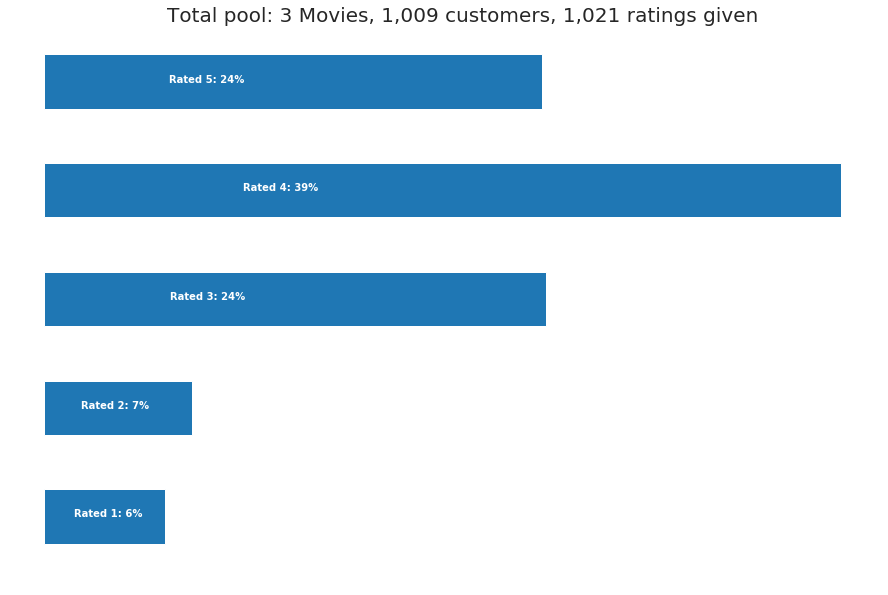

In [162]:
#Seeing the distribution of ratings given by the users
print("See Overview of the Data")
p = df.groupby('Rating')['Rating'].agg(['count'])
# get movie count
movie_count = df.isnull().sum()[1]
# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count
# get rating count
rating_count = df['Cust_Id'].count() - movie_count
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rated {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [165]:
#Adding movie IDs to the dataset
movie_np = []
movie_id = 0
for x in range(df.shape[0]):
    if(np.isnan(df.iloc[x]['Rating'])):
        movie_id = movie_id+1
    movie_np = np.append(movie_np,movie_id)

#print(movie_np)
#print(len(movie_np))
df['Movie_Id'] = movie_np.astype(int)
print("Movie IDs extracted from the extra rows given")

Movie IDs extracted from the extra rows given


In [167]:
# remove the extra Movie ID rows
df = df[pd.notnull(df['Rating'])]
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::100, :])


print("\n\nThese are the final datatypes of the dataset")
print(df.dtypes)

-Dataset examples-
      Cust_Id  Rating        Date  Movie_Id
1     1488844     3.0  20050906.0         1
101   1155747     3.0  20050703.0         1
201   1141189     4.0  20041215.0         1
301   2256485     1.0  20040819.0         1
401   2322840     3.0  20050712.0         1
501     45117     5.0  20050815.0         1
602   2596999     4.0  20051007.0         2
703   1644750     3.0  20030319.0         3
803    372528     3.0  20040630.0         3
903   1115632     3.0  20031124.0         3
1003  2085230     4.0  20040315.0         3


These are the final datatypes of the dataset
Cust_Id       int64
Rating      float64
Date        float64
Movie_Id      int64
dtype: object


In [168]:
#Creating Data Matrix
df_matrix=pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_matrix.shape)

(1009, 3)


In [157]:
#Loading the Movie ID- Movie Title Mapping File

df_title = pd.read_csv('netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print("See some Movie ID- Movie Title Mapping : \n")
print (df_title.head(8))

See some Movie ID- Movie Title Mapping : 

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?


In [158]:
print("\n\nData Cleaning Complete.\n See head of the Data Matrix:\n")
print(df_matrix.head())



Data Cleaning Complete.
 See head of the Data Matrix:

Movie_Id    1   2    3
Cust_Id               
915       5.0 NaN  NaN
1333      NaN NaN  4.0
2442      3.0 NaN  NaN
3321      3.0 NaN  NaN
4326      4.0 NaN  NaN
